In [1]:
from generator import Generator
from critic import Critic
from dog_dataset import DogData

In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torch import optim

In [3]:
batchSize = 1

In [4]:
transform = transforms.Compose( [ transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) ] )
dogdata = DogData(transform)
dogloader = DataLoader(dogdata, shuffle=True, batch_size=batchSize, num_workers=3)

In [5]:
import matplotlib.pyplot as plt

In [6]:
gen_img = torch.randn([1, 3, 100, 100], requires_grad=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


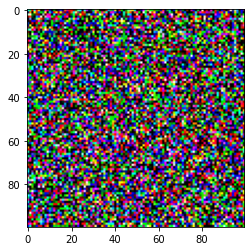

In [7]:
plt.imshow(gen_img[0].permute(1,2,0).detach())
plt.show()

In [8]:
def get_critic_scores(real_batch, batchSize, critic):
    #generator.batchSize = batchSize
    critic.batchSize = batchSize
    #generate fake images
    #randoBatch = torch.rand([batchSize, 100, 1, 1])
    #generated = generator(randoBatch)
    generated = gen_img
    #compute scores of both real and fake using the critic
    real_scores = critic(real_batch[0])
    gen_scores = critic(generated)
    return ( torch.sum(real_scores) , torch.sum(gen_scores) )

In [9]:
def get_generator_score(batchSize, critic):
    #generator.batchSize = batchSize
    #generate fake images
    #randoBatch = torch.rand([batchSize, 100, 1, 1])
    #generated = generator(randoBatch)
    generated = gen_img
    #compute scores of generated using critic
    gen_scores = critic(generated)
    return gen_scores#torch.sum(gen_scores)

In [10]:
class WeightClipper(object):

    def __init__(self, frequency=5):
        self.frequency = frequency

    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = w.clamp(-0.01,0.01)
            module.weight.data = w

In [11]:
critic = Critic()
generator = Generator()
clipper = WeightClipper()
critic.apply(clipper)

Critic(
  (convBlocks): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (fcBlocks): Sequential(
    (0): Sequential(
      (0): Linear(in_features=67712, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [12]:
num_epochs = 100
critic_epochs = 1
gen_epochs = 1

In [13]:
criticOptim = optim.RMSprop(critic.parameters(), lr=0.0005)#, momentum=0)
genOptim = optim.RMSprop([gen_img], lr=0.05, momentum=0)

In [14]:
for epoch in range(num_epochs):
    print('Entering epoch yay: ' + str(epoch))
    realScore = 0.0 
    fakeScore = 0.0
    mainLoss = 0.0
    #critic training loop
    for batch_no, batch in enumerate(dogloader):
        if (critic_epochs == 0):
            break
        print('Critic batch: ' + str(batch_no))
        scores = get_critic_scores(batch, batchSize, critic)
        real_score = scores[0]
        gen_score = scores[1]
        #loss function
        loss = -( real_score - gen_score ) #+ 0.01 * ( torch.pow(real_score,2) + torch.pow(gen_score,2) ) #penalize for distance away from 0
        #some tracking of numbers here
        realScore += real_score.item()
        fakeScore += gen_score.item()
        mainLoss += loss.item()
        #optimize
        criticOptim.zero_grad()
        loss.backward()
        criticOptim.step()
        
        if (batch_no % critic_epochs == critic_epochs-1):
            break
    print(realScore)
    print(fakeScore)
    print(mainLoss)
    
    mainLoss = 0.0
    #generator training loop
    for gepoch in range(gen_epochs):
        print('Generator batch: ' + str(gepoch))
        gen_score = get_generator_score(batchSize, critic)
        #loss function
        loss = -gen_score
        #tracking of numbers
        mainLoss += loss.item()
        #optimize
        genOptim.zero_grad()
        loss.backward()
        genOptim.step()
    print(mainLoss)

Entering epoch yay: 0
Critic batch: 0
-0.08747392147779465
-0.08747466653585434
-7.450580596923828e-07
Generator batch: 0
0.08780887722969055
Entering epoch yay: 1
Critic batch: 0
-0.08644285053014755
-0.08733675628900528
-0.000893905758857727
Generator batch: 0
0.15986260771751404
Entering epoch yay: 2
Critic batch: 0
-0.010896064341068268
-0.03908049687743187
-0.0281844325363636
Generator batch: 0
-1.962527871131897
Entering epoch yay: 3
Critic batch: 0
3.115863561630249
3.3189332485198975
0.20306968688964844
Generator batch: 0
0.8147838115692139
Entering epoch yay: 4
Critic batch: 0
-0.7903978824615479
-0.7706409692764282
0.01975691318511963
Generator batch: 0
0.474238783121109
Entering epoch yay: 5
Critic batch: 0
-0.4153164327144623
-0.44262340664863586
-0.027306973934173584
Generator batch: 0
1.1735315322875977
Entering epoch yay: 6
Critic batch: 0
-0.7881714701652527
-0.7005406618118286
0.08763080835342407
Generator batch: 0
0.04984753206372261
Entering epoch yay: 7
Critic batch

Critic batch: 0
1.273127794265747
1.2972397804260254
0.02411198616027832
Generator batch: 0
-1.1350388526916504
Entering epoch yay: 61
Critic batch: 0
1.1441985368728638
1.1662075519561768
0.02200901508331299
Generator batch: 0
-1.023317813873291
Entering epoch yay: 62
Critic batch: 0
1.033354640007019
1.041519284248352
0.008164644241333008
Generator batch: 0
-0.9362085461616516
Entering epoch yay: 63
Critic batch: 0
0.9414934515953064
0.9517661929130554
0.010272741317749023
Generator batch: 0
-0.7957822680473328
Entering epoch yay: 64
Critic batch: 0
0.8067061305046082
0.8064694404602051
-0.00023669004440307617
Generator batch: 0
-0.7145125865936279
Entering epoch yay: 65
Critic batch: 0
0.7299523949623108
0.7268539071083069
-0.0030984878540039062
Generator batch: 0
-0.6673378944396973
Entering epoch yay: 66
Critic batch: 0
0.6885027885437012
0.67911297082901
-0.009389817714691162
Generator batch: 0
-0.6315340995788574
Entering epoch yay: 67
Critic batch: 0
0.6458969712257385
0.651570

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


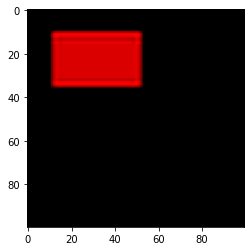

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.6023]], grad_fn=<AddmmBackward>)
tensor([[0.6070]], grad_fn=<AddmmBackward>)


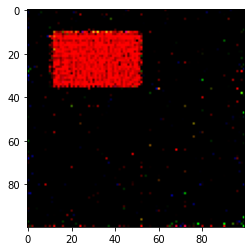

In [15]:
plt.imshow(dogdata[0][0].permute(1,2,0))
plt.show()

critic.batchSize = 1
critic.eval()
print(critic(dogdata[800][0].unsqueeze(0)))
rando = torch.rand([1, 100, 1, 1])
print(critic(gen_img))

gen = generator(rando)
plt.imshow(gen_img[0].permute(1,2,0).detach().numpy())
plt.show()